In [1]:
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.optim as optim

from PIL import Image

# Loading the dataset

In [2]:
X = np.load("./X.npy")
y = np.load("./Y.npy")

In [3]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (22801, 128, 128, 3)
Shape of y: (22801, 1)


In [4]:
num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

Number of classes: 27


In [5]:
print("Dimensions of a single image:", X[0].shape)

Dimensions of a single image: (128, 128, 3)


# Defining transformations for the images

In [6]:
image_size=32
mean=0
stddev=1

In [7]:
X = X.astype(np.float32)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (stddev,))
])
X_transformed = torch.stack([transform(image) for image in X])

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.ravel())
y_transformed = torch.tensor(y_encoded)

In [9]:
X_transformed.shape, y_transformed.shape

(torch.Size([22801, 3, 32, 32]), torch.Size([22801]))

# Splitting the dataset into train, validation, and test sets


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Creating DataLoaders for training, validation, and testing

In [11]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the shapes of the datasets

In [13]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: torch.Size([18240, 3, 32, 32])
Shape of y_train: torch.Size([18240])
Shape of X_val: torch.Size([2280, 3, 32, 32])
Shape of y_val: torch.Size([2280])
Shape of X_test: torch.Size([2281, 3, 32, 32])
Shape of y_test: torch.Size([2281])


In [14]:
# Funkcija za računanje izlaznih dimenzija nakon konvolucije
def calculate_h_out_w_out(h_in, w_in, kernel_size, out_channels, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    h_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0] + 1
    w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1

    # assert
    assert isinstance(h_out, int), "Output height is not an integer"
    assert isinstance(w_out, int), "Output width is not an integer"
    
    return (h_out, w_out, out_channels)

# Definišemo klasu modela
class CNN(nn.Module):
    def __init__(self, in_height, in_width, in_channels, num_classes):
        super(CNN, self).__init__()

        self.in_features = (in_height, in_width, in_channels)
        
        # Prvi konvolucioni sloj
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.in_features = calculate_h_out_w_out(in_height, in_width, (5, 5), 16, padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        
        # Drugi konvolucioni sloj
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (5, 5), 32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        
        # Treći konvolucioni sloj
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (3, 3), 64, padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        
        # Linearni slojevi
        self.fc1 = nn.Linear(in_features=self.in_features[0] * self.in_features[1] * self.in_features[2], out_features=1024)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)  # Flatten za linearne slojeve
        
        x = self.fc1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.logSoftmax(x)
        return x


In [15]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

In [17]:
def train(model, criterion, optimizer, n_epochs, train_loader, valid_loader, multiclass=False):
    # Initialize lists for traininf and validation loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    # Get the appropriate device
    device = get_device()

    # Iterate over each epoch
    for epoch in range(n_epochs):
        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> TRAINING <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.train()                                # Set the model to training mode
        
        epoch_train_batches_loss = 0.0               # Loss for the current epoch
        epoch_train_correct_predictions = 0          # Number of correct predictions
        epoch_train_total_predictions = 0            # Total number of instances processed

        # Iterate over batches in the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Gradients from the previous batch are zeroed out to prevent accumulation
            optimizer.zero_grad()
            
            # Compute the model output
            outputs = model(inputs)
            
            # Compute the loss based on the criterion passed 
            loss = criterion(outputs.squeeze(), labels)
            
            # Compute the gradients
            loss.backward()
            
            # Update the model parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current batch
            epoch_train_batches_loss += loss.item()

            # Predict
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
            
            # Update the number of correct predictions
            epoch_train_correct_predictions += (predicted.squeeze() == labels).sum().item()
            
            # Update the total number of instances processed
            epoch_train_total_predictions += labels.size(0)

        # Calculate the average loss for the training epoch
        epoch_train_loss = epoch_train_batches_loss / len(train_loader)
        
        # Calculate the accuracy for the training epoch
        epoch_train_accuracy = epoch_train_correct_predictions / epoch_train_total_predictions
        
        # Store the loss and accuracy for training
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> VALIDATION <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.eval()                               # Set the model to evaluation mode
        
        epoch_valid_loss = 0.0                       # Loss for the current validation epoch
        epoch_valid_correct_predictions = 0          # Number of correct predictions
        epoch_valid_total_predictions = 0            # Total number of instances processed
        
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in valid_loader:
                # Move inputs and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the model output
                outputs = model(inputs)
                
                # Compute the loss based on the criterion passed 
                loss = criterion(outputs.squeeze(), labels)
                
                # Accumulate the loss for the current batch
                epoch_valid_loss += loss.item()

                # Predict
                if multiclass:
                    predicted = torch.argmax(outputs, dim=1)
                else:
                    predicted = (outputs > 0.5).float()
                
                # Update the number of correct predictions
                epoch_valid_correct_predictions += (predicted.squeeze() == labels).sum().item()
                
                # Update the total number of instances processed
                epoch_valid_total_predictions += labels.size(0)
        
        # Calculate the average loss and accuracy for the validation epoch
        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy = epoch_valid_correct_predictions / epoch_valid_total_predictions

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_valid_loss:.4f}, Val Accuracy: {epoch_valid_accuracy:.4f}")

    # Return the losses and accuracies over all epochs
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [18]:
image_height = image_size
image_width = image_size
n_channels = X.shape[3]
print(image_height, image_width, n_channels)
n_classes = len(np.unique(y))

32 32 3


In [19]:
model = CNN(in_height=image_height, in_width=image_width, in_channels=n_channels, num_classes=n_classes)
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=27, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [20]:
count_parameters(model)

Layer: conv1, Parameters: 1216
Layer: relu1, Parameters: 0
Layer: maxpool1, Parameters: 0
Layer: conv2, Parameters: 12832
Layer: relu2, Parameters: 0
Layer: maxpool2, Parameters: 0
Layer: conv3, Parameters: 18496
Layer: relu3, Parameters: 0
Layer: maxpool3, Parameters: 0
Layer: fc1, Parameters: 590848
Layer: dropout1, Parameters: 0
Layer: fc2, Parameters: 27675
Layer: logSoftmax, Parameters: 0


651067

In [21]:
n_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [22]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, criterion, optimizer, n_epochs, train_loader, val_loader, True)


Epoch [1/100], Train Loss: 2.6147, Train Accuracy: 0.2160, Val Loss: 1.7165, Val Accuracy: 0.4404
Epoch [2/100], Train Loss: 1.3849, Train Accuracy: 0.5559, Val Loss: 1.1609, Val Accuracy: 0.6224
Epoch [3/100], Train Loss: 0.9313, Train Accuracy: 0.6992, Val Loss: 0.8721, Val Accuracy: 0.7289
Epoch [4/100], Train Loss: 0.7070, Train Accuracy: 0.7693, Val Loss: 0.6923, Val Accuracy: 0.7776
Epoch [5/100], Train Loss: 0.5693, Train Accuracy: 0.8139, Val Loss: 0.6463, Val Accuracy: 0.7912
Epoch [6/100], Train Loss: 0.4712, Train Accuracy: 0.8473, Val Loss: 0.5456, Val Accuracy: 0.8184
Epoch [7/100], Train Loss: 0.4077, Train Accuracy: 0.8656, Val Loss: 0.5359, Val Accuracy: 0.8338
Epoch [8/100], Train Loss: 0.3511, Train Accuracy: 0.8828, Val Loss: 0.5155, Val Accuracy: 0.8425
Epoch [9/100], Train Loss: 0.2988, Train Accuracy: 0.9024, Val Loss: 0.4925, Val Accuracy: 0.8553
Epoch [10/100], Train Loss: 0.2760, Train Accuracy: 0.9101, Val Loss: 0.5322, Val Accuracy: 0.8447
Epoch [11/100], Tra

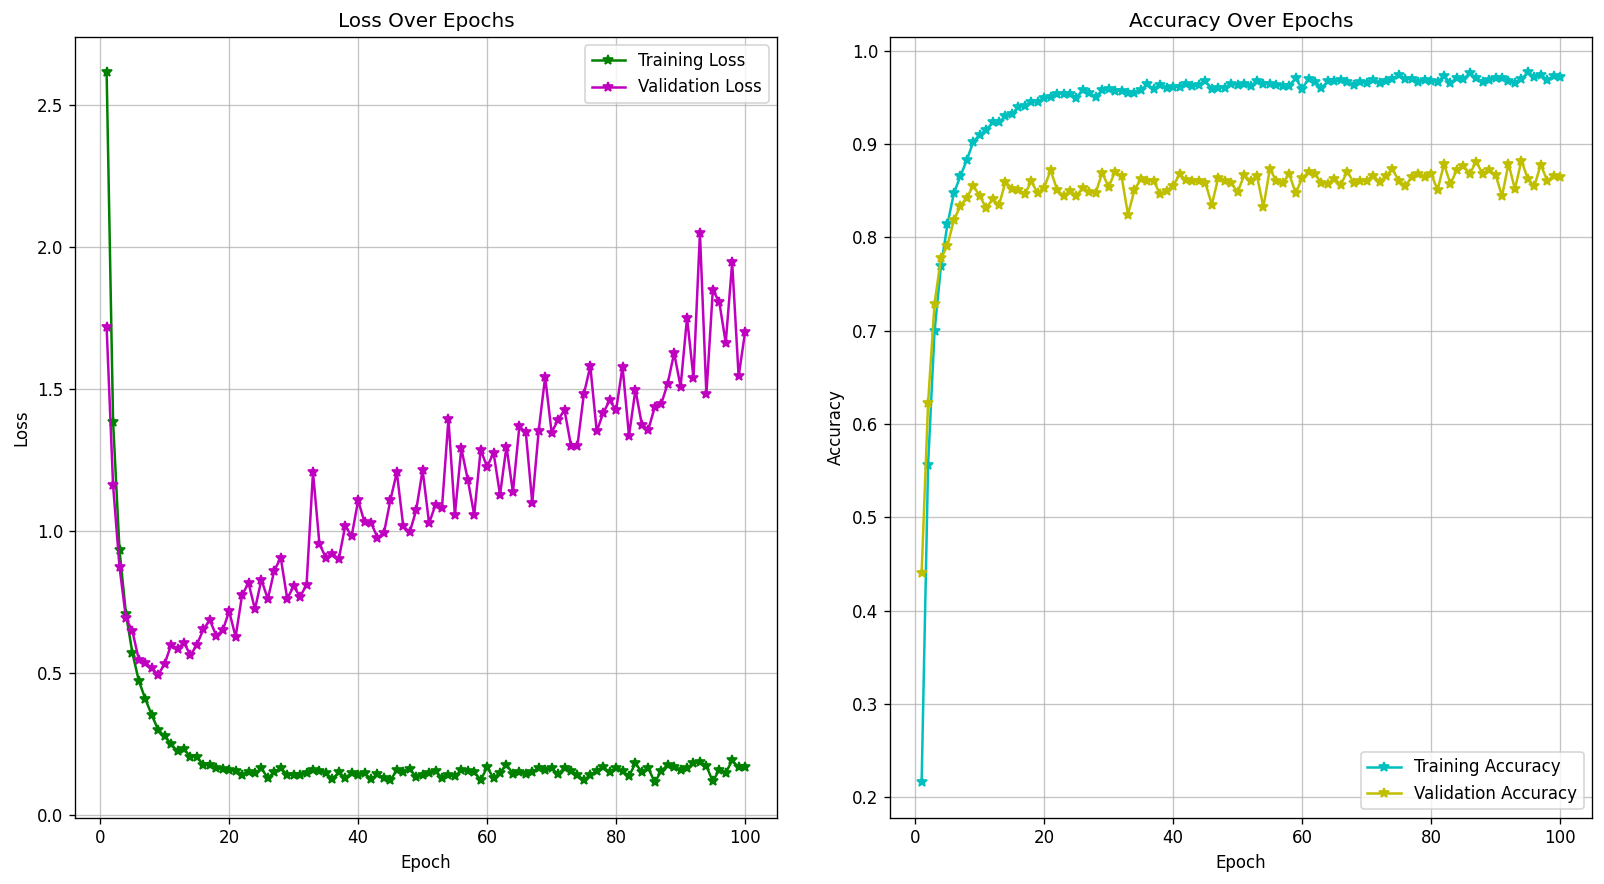

In [37]:
import matplotlib.pyplot as plt

def visualize_training_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies):
    fig_size = (14, 8)
    plot_resolution = 120
    grid_alpha = 0.75

    epoch_numbers = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=fig_size, dpi=plot_resolution)
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epoch_numbers, train_losses, 'g*-', label='Training Loss')
    plt.plot(epoch_numbers, valid_losses, 'm*-', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True, alpha=grid_alpha)
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_numbers, train_accuracies, 'c*-', label='Training Accuracy')
    plt.plot(epoch_numbers, valid_accuracies, 'y*-', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True, alpha=grid_alpha)
    
    plt.tight_layout(pad=3.0)
    plt.show()

# Pozivanje funkcije sa podacima
visualize_training_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies)


In [38]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate(model, criterion, loader, multiclass=False):
    # Set the model to evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    predicted_labels, true_labels = [], []
    
    # Get the device
    device = get_device()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            
            # Compute loss
            total_loss += criterion(outputs.squeeze(), labels).item()

            # Predict class labels
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
                
            # Append predictions and true labels for metric computation
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            # Update total samples and correct predictions count
            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    
    # Print evaluation results
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d',  xticklabels=classes_names,  yticklabels=classes_names)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # Average loss over all batches
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x0000016D942EA840>
Accuracy: 0.8649
Precision: 0.8675
Recall: 0.8649
F1 Score: 0.8643


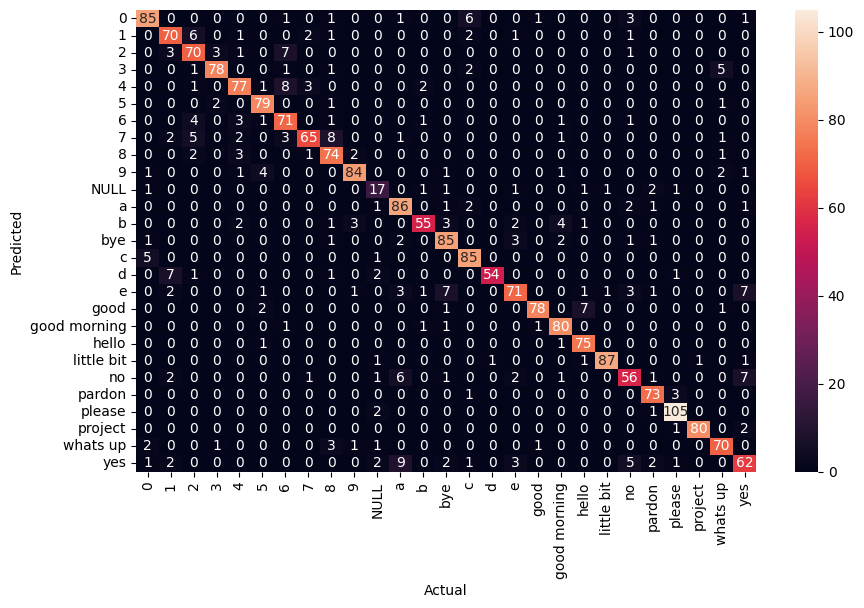

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x0000016D9203BD40>
Accuracy: 0.8645
Precision: 0.8663
Recall: 0.8645
F1 Score: 0.8641


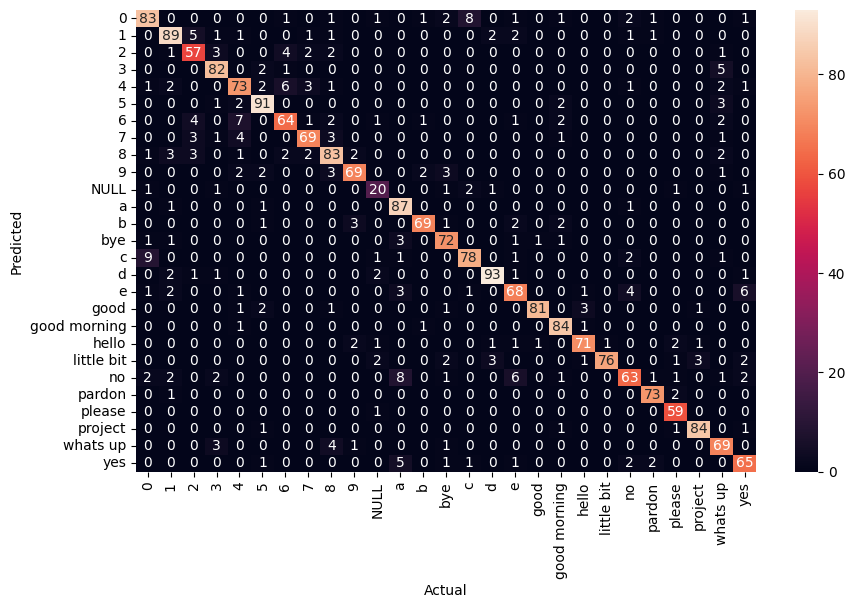

In [39]:
classes_names = np.unique(y)
# Evaluate on validation and test sets
print("="*150)
valid_loss, val_accuracy = evaluate(model, criterion, val_loader, multiclass=True)
print("="*150)
test_loss, test_accuracy = evaluate(model, criterion, test_loader, multiclass=True)